<a href="https://colab.research.google.com/github/simulate111/Johdatus-teko-lyyn-Introduction-to-Artificial-Intelligence/blob/main/JT_H3_En_Solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, roc_auc_score, auc
from sklearn.preprocessing import minmax_scale
from skimage.feature import hog
from skimage import io
from skimage.filters import threshold_sauvola
from skimage.color import rgb2gray
from skimage.transform import resize
from scipy import ndimage
from skimage import measure
import matplotlib.patches as mpatches
from imblearn.over_sampling import SVMSMOTE
plt.rcParams['figure.figsize'] = (15, 6)

In [4]:
!pip install onedrivedownloader

In [5]:
from onedrivedownloader import download

link2data = 'https://unioulu-my.sharepoint.com/:u:/g/personal/jukmaatt_univ_yo_oulu_fi/ET3iUnWprHVGqjKavqhFmz4BpCN4WGYrSovJNbIBzkD3JQ?e=SK1SlV'

if not os.path.exists('./data'):
    print('Downloading data')
    download(link2data, filename='./files.zip', unzip=True, unzip_path='./')

# <center>521160P Introduction to artificial intelligence<br><br>Exercise #3<br><br>Classification<br></center>

This exercise validates the optimal values of hyperparameters for classifiers and compares the effect of balanced and unbalanced teaching data on classifier performance. **Look return deadlines from moodle**. (Return instructions for this exercise are sligthly different from previous ones). It is possible to get 4 points from this exercise (2.0p + 2.0p).

If you have any questions related to exercises or you face any problems during this exercise please use moodle forum for **programming exercise 3**.

**First fill in your group information (name and student number)**

# Group member information :

* **Member 1 :** `...`
* **Member 2 :** `...`
* **Member 3 :** `... `

# Task 1. Classifier validation and testing

This task teaches three different classifiers to classify MNIST data, validate classifiers, and evaluate classifier performance. MNIST data contains handwritten numbers from 0 to 9. For each category, the data contains 7000 samples, i.e. it is balanced data. In total, the MNIST data contain 70,000 samples collected from U.S. Census staff and high school students. The data samples are scaled to 20x20 pixel grayscale images and finally centered on a 28x28 pixel grid. The classification accuracies of simple classifiers taught with this data range between 80% and 99%. Figure 1 shows sample samples of ten classes of MNIST data.

<br>
<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='https://github.com/simulate111/Johdatus-teko-lyyn-Introduction-to-Artificial-Intelligence/blob/main/imgs/mnist.png?raw=1' width='650' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Figure 1. Sample images of ten classes of MNIST data.</span>
</div>
<br>

Data samples are not fed directly to the classification algorithms, but image preprocessing achieves a better result. HOG (histogram of oriented gradients) is chosen as the data preprocessing method.

The HOG method calculates a feature vector for an image that is nearly identical to the same image with different contrast values. Initially, the method divides the input image into blocks. For each pixel in the block, a gradient is calculated that tells you the direction and magnitude of the darkening of the image. By placing the gradients of the block in the histogram, the HOG features of the block are obtained. Figure 2 calculates the HOG features for the MNIST data sample and finally visualizes them in the initial image. The input image is divided into 16 blocks and gradients are thresholded every 40 degrees.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='https://github.com/simulate111/Johdatus-teko-lyyn-Introduction-to-Artificial-Intelligence/blob/main/imgs/hog.png?raw=1' width='750' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Figure 2. HOG features for the MNIST data sample.</span>
</div>
<br>

Use 10,000 samples instead of the original 70,000 samples in this task. Divide the calculated HOG features by the [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function of the scikit-learn library with teaching, validation and test data in an 80:10:10 division ratio. After distribution, there are 8000 samples in the teaching data, 1000 samples in the validation data and 1000 samples in the test data.

In [6]:
# Load MNIST data. Data includes 784 variables (28x28 grayscale) and data's class information.
data, classes = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
data, classes = np.asarray(data, 'int16'), np.asarray(classes, 'int')
data, classes = data[:10000], classes[:10000]

# For Images calculate HOG-features
features = []
for sample in data:
    features.append(hog(sample.reshape((28, 28)), orientations=9, pixels_per_cell=(7, 7), cells_per_block=(1, 1), block_norm="L2-Hys", visualize=False))

# Divide features into teaching data, validation data and test data in two stages
data_teaching, data_tmp, classes_teaching, classes_tmp = train_test_split(features, classes, test_size=(1/5), random_state=0)
data_test, data_validate, classes_test, classes_validate = train_test_split(data_tmp, classes_tmp, test_size=(1/2), random_state=0)

# Print teaching data, validation data and test data sample ammount
print('teaching data has {} samples'.format(classes_teaching.shape[0]))
print('validate data has {} samples'.format(classes_validate.shape[0]))
print('test data has {} samples'.format(classes_test.shape[0]))

teaching data has 8000 samples
validate data has 1000 samples
test data has 1000 samples


Next, validation data is used to find optimal hyperparameter values for the k-nearest Neighbors (k-NN), linear support vector machines (linear SVM), and logistic regression.

## Validating k-nearest neigbors classifier

Start validation on the number of neighbors $ k $ of the [k-nearest neighbor classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier). Let's go through the loop $ k $ values 1-33 every four steps. Then the effect of the value of $ k $ on the classification accuracy is plotted on the graph and the best value of $ k $ is selected from the graph.

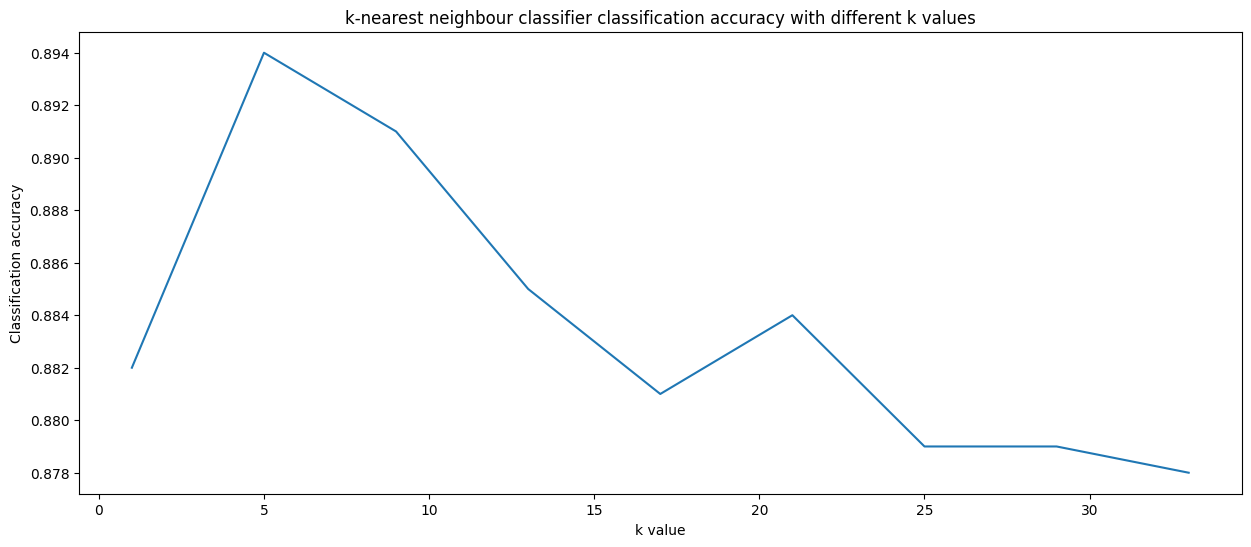

Best value k value for k-nearest neighbour classifier: 5


In [7]:
# Perform validation of k-nearest neighbour classifier

# Loop through values from 1 to 33 with steps of 4
classification_accuracy_knn = []
k_values = range(1,34,4)
for k in k_values:
    classifier_knn = KNeighborsClassifier(n_neighbors=k).fit(data_teaching, classes_teaching)
    classification_accuracy_knn.append(accuracy_score(classes_validate, classifier_knn.predict(data_validate)))

# Plot a graph with different k values to see how it affects classification accuracy
plt.plot(k_values, classification_accuracy_knn)
plt.title('k-nearest neighbour classifier classification accuracy with different k values')
plt.xlabel('k value')
plt.ylabel('Classification accuracy')
plt.show()

# Finally choose best k value from graph
maximum_index_knn = np.argmax(classification_accuracy_knn)
print('Best value k value for k-nearest neighbour classifier: {}'.format(k_values[maximum_index_knn]))

## Validation of a linear support vector machine

The support vector machine tries to match the decision level between the classes so that the margin between the classes is as large as possible. For a linear support vector machine, the most important value of the hyperparameter is $C$. Its magnitude indicates how much is avoided from misclassifying samples of teaching data. Large values of $C$ can emphasize a smaller choice of marginal decision levels if they lead to a better classification result for teaching data. Small values of $C$, in turn, emphasize the choice of higher margin decision levels at the expense of the teaching data classification result.

Next, validate the value of the hyperparameter $C$ of the [linear support vector machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html). Let's loop through the $C$ values $10 ^{n}$, where $n$ is -5, -4, ..., 14, 15. Then plot the effect of the exponent value of $ $ on the classification accuracy and select the best value of $C$ from the graph.

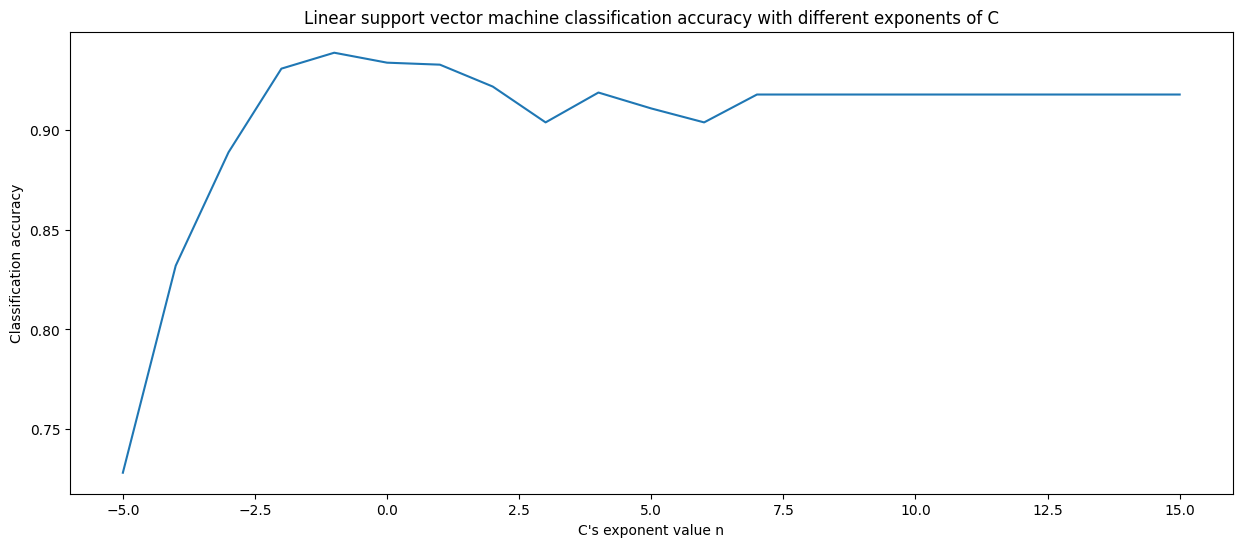

Best C value for linear support vector machine: 10^(-1.0)


In [8]:
# Perform validation of linear support vector machine
# Loop through exponent values of C -5 to 15
classification_accuracy_linear_svm = []
n1 = np.array(range(-5,16),dtype=float)
C1_values = 10**n1
for C1 in C1_values:
    classifier_linear_svm = LinearSVC(C=C1, random_state=0).fit(data_teaching, classes_teaching)
    classification_accuracy_linear_svm.append(accuracy_score(classes_validate, classifier_linear_svm.predict(data_validate)))

# Plot a graph with different exponents of C to see how it affects classification accuracy
plt.plot(n1, classification_accuracy_linear_svm)
plt.title('Linear support vector machine classification accuracy with different exponents of C')
plt.xlabel('C\'s exponent value n')
plt.ylabel('Classification accuracy')
plt.show()

# Finally choose best C value from graph
maximum_index_linear_svm = np.argmax(classification_accuracy_linear_svm)
print('Best C value for linear support vector machine: 10^({})'.format(n1[maximum_index_linear_svm]))

## Validation of logistic regression classifier
Finally validate [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) using hyperparameter $C$. It regulates the intensity of the regularization of the classifier. Let's loop through $C$ values $10^{n}$, where $n$ is -5, -4, ..., 14, 15. Then plot the effect of the exponent value of $C$ on the classification accuracy and select the best value of $C$ from the graph.

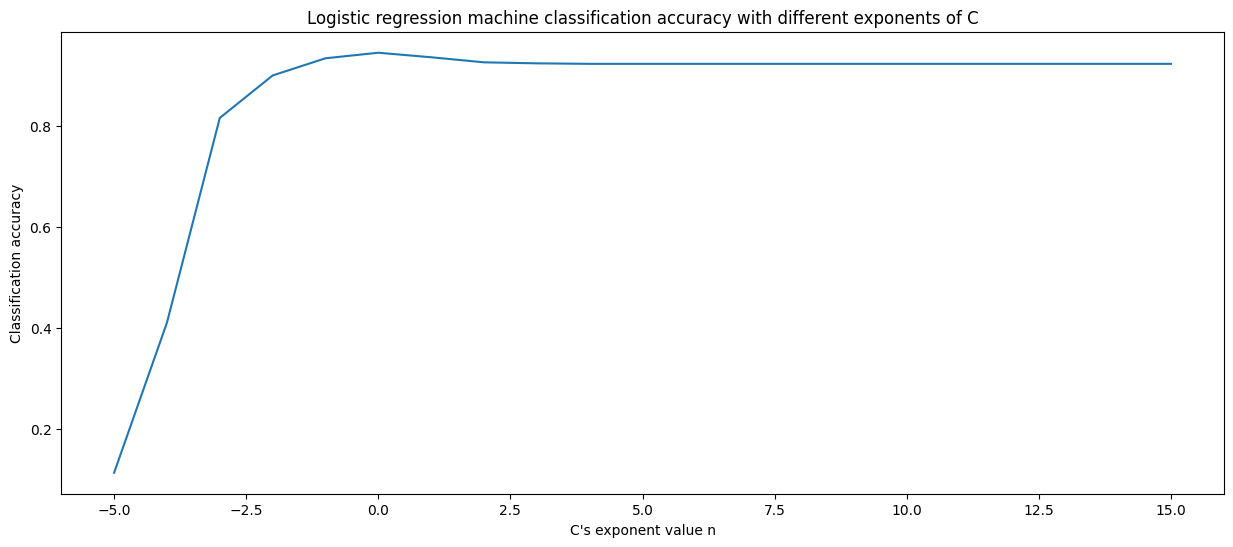

Best C value for logistic regression: 10^(0.0)


In [9]:
# Perform validation of logistic regression
# Loop through exponent values of C from -5 to 15
classification_accuracy_logistic_regression = []
n2 = np.array(range(-5,16),dtype=float)
C2_values = 10**n2
for C2 in C2_values:
    classifier_logistic_regression = LogisticRegression(C=C2, solver='sag', random_state=0).fit(data_teaching, classes_teaching)
    classification_accuracy_logistic_regression.append(accuracy_score(classes_validate, classifier_logistic_regression.predict(data_validate)))

# Plot a graph with different exponents of C to see how it affects classification accuracy
plt.plot(n2, classification_accuracy_logistic_regression)
plt.title('Logistic regression machine classification accuracy with different exponents of C')
plt.xlabel('C\'s exponent value n')
plt.ylabel('Classification accuracy')
plt.show()

# Finally choose best C value from graph
maximum_index_logistic_regression = np.argmax(classification_accuracy_logistic_regression)
print('Best C value for logistic regression: 10^({})'.format(n2[maximum_index_logistic_regression]))

Once the best values of the classifiers hyperparameters have been determined, extract them and teach them using the final classifiers. Thus, you should give the best value of $k$ to the classifier of the k-nearest neighbor, the best exponent of $C$ for a linear support vector machine, and the best exponent of $C$ for logistic regression $n_2$.

In [10]:
# Teach classifier with best k, n, and n2 values
#-------- Your code here --------
k = k_values[maximum_index_knn]
n1 = n1[maximum_index_linear_svm]
n2 = n2[maximum_index_logistic_regression]
#-----------------------------------

classifier_knn_validate = KNeighborsClassifier(n_neighbors=k).fit(data_teaching, classes_teaching)
classifier_linear_svm_validate = LinearSVC(C=10**(n1), random_state=0).fit(data_teaching, classes_teaching)
classifier_logistic_regression_validate = LogisticRegression(C=10**(n2), solver='sag', random_state=0).fit(data_teaching, classes_teaching)

Next, the performance of classifiers is evaluated based on confusion matrices and classification accuracies.

Classification accuracy for k-nearest neighbour: 89.5 %
Classification accuracy for linear support vector machine: 94.0 %
Classification accuracy for logistic regression: 94.6 %


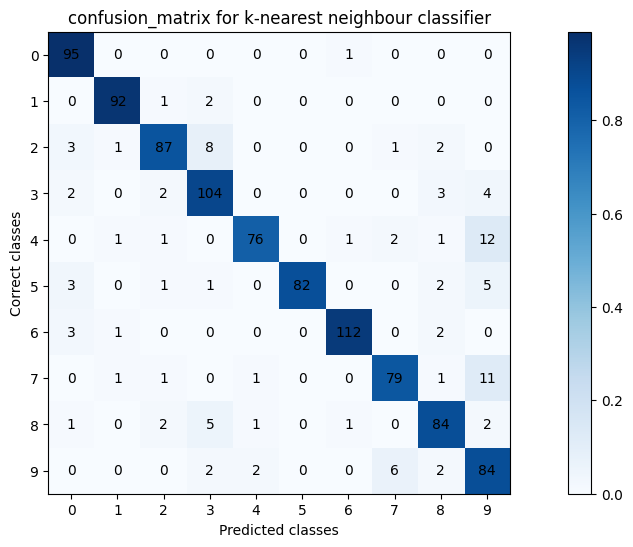

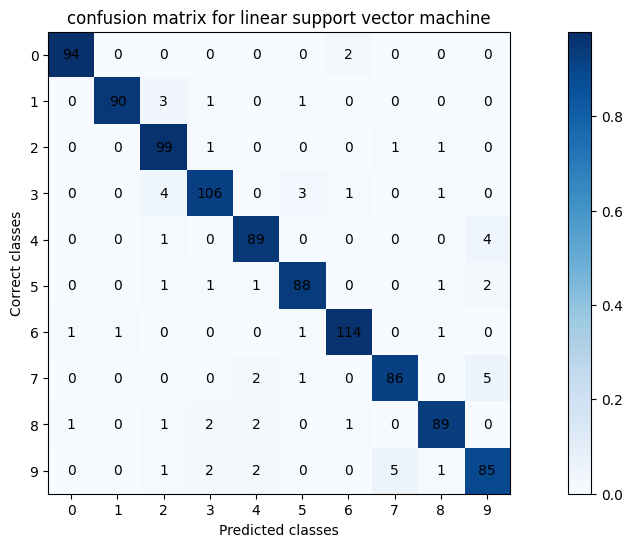

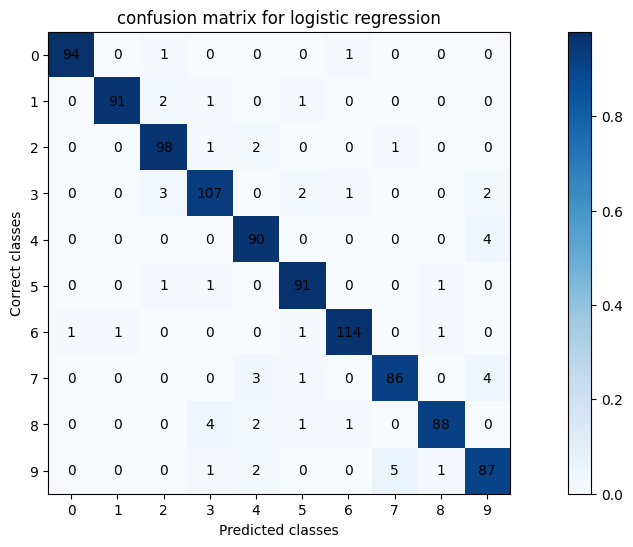

In [11]:
def print_confusion_matrix(conf_matrix, title):
    """
    This function prints confusion matrix
    """
    normalized_values = []
    for row in conf_matrix:
        summ = 0
        values = []
        summ = sum(row, 0)
        for value in row:
            values.append(float(value)/float(summ))
        normalized_values.append(values)
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    colors = ax.imshow(np.array(normalized_values), cmap=plt.cm.Blues, interpolation='nearest')
    width, height = conf_matrix.shape
    for i in range(width):
        for j in range(height):
            ax.annotate(str(conf_matrix[i][j]), xy=(j, i), horizontalalignment='center', verticalalignment="center")
    fig.colorbar(colors)
    classes = '0123456789'
    plt.xticks(range(width), classes[:width])
    plt.yticks(range(height), classes[:height])
    plt.title(title)
    plt.xlabel("Predicted classes")
    plt.ylabel("Correct classes")

# Predict classes with validated k-nearest neighbour, place predicted classes in confusion matrix and calculate classification accuracy
classes_predicted_knn = classifier_knn_validate.predict(data_test)
print_confusion_matrix(confusion_matrix(classes_test, classes_predicted_knn), 'confusion_matrix for k-nearest neighbour classifier')
print('Classification accuracy for k-nearest neighbour: {} %'.format(round(100*accuracy_score(classes_test, classes_predicted_knn),3)))

# Predict classes with validated linear support vector machine, place predicted classes in confusion matrix and calculate classification accuracy
classes_predicted_linear_svm = classifier_linear_svm_validate.predict(data_test)
print_confusion_matrix(confusion_matrix(classes_test, classes_predicted_linear_svm), 'confusion matrix for linear support vector machine')
print('Classification accuracy for linear support vector machine: {} %'.format(round(100*accuracy_score(classes_test, classes_predicted_linear_svm),3)))

# Predict classes with validated logistic regression, place predicted classes in confusion matrix and calculate classification accuracy
classes_predicted_logistic_regression = classifier_logistic_regression_validate.predict(data_test)
print_confusion_matrix(confusion_matrix(classes_test, classes_predicted_logistic_regression), 'confusion matrix for logistic regression')
print('Classification accuracy for logistic regression: {} %'.format(round(100*accuracy_score(classes_test, classes_predicted_logistic_regression),3)))
plt.show()

**Which of the validated classifiers is the best in terms of classification accuracy? By interpreting confusion_matrix, in which category (ies) does the classifier of the k-nearest neighbor most often confuse the handwritten number 4?**

`Generally linear support vector machine seems to works better with higher accuracy followed by logistic regression.

In all models, number 4 is mixed up with number 9.`

Finally test how well validated k-nearest neighbour classifier performs for three test images. The handwritten numbers are segmented from the image by Sauvola's binarization method, after which red rectangles are drawn around the numbers. Finally, a validated k-nearest neighbor classifier is used to identify handwritten numbers in the images. The projections are drawn in the figure with red numbers below the rectangles.

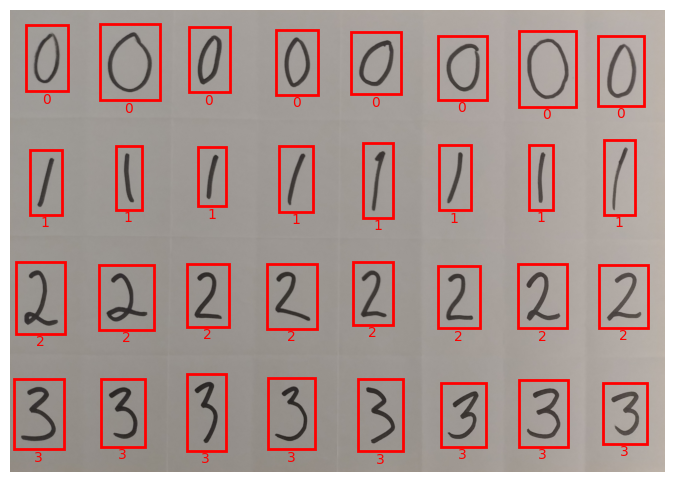

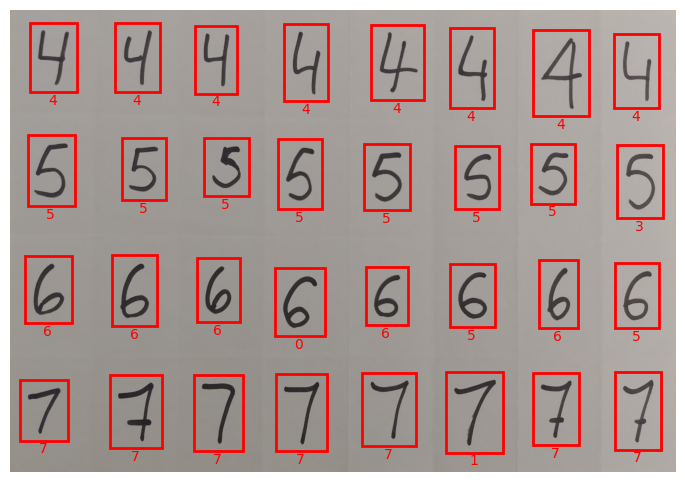

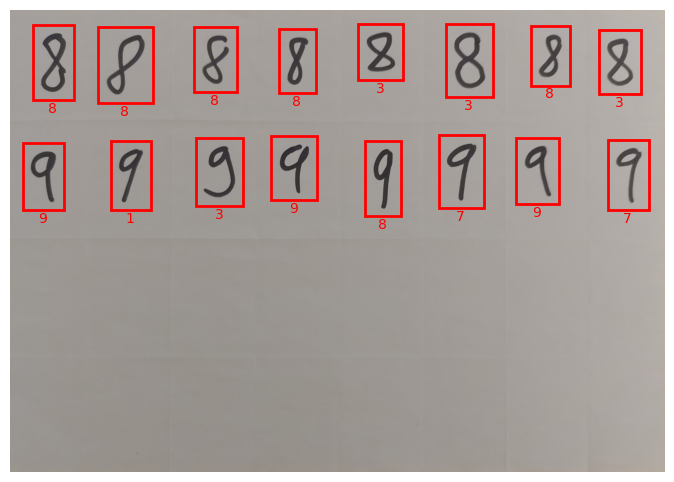

In [12]:
def recognize_number_and_classify(img, classifier):
    """
    This function recognizes handwritten numbers in an image,
    calculates HOG features for them, and classifies them based on features
    """
    plt.figure()
    plt.axis('off')

    # Filter image
    grayscale_img = rgb2gray(img)
    threshold = threshold_sauvola(grayscale_img, window_size=155)
    binarization_sauvola = grayscale_img > threshold
    filtered_img = ndimage.median_filter(binarization_sauvola, size=15)

    # Find rectangles
    outlines = measure.find_contours(filtered_img, 0)
    rectangles = []
    offset = 25
    for outline in outlines:
        # xmin, xmax, ymin, ymax
        rectangles.append([int(np.min(outline[:,0])-offset), int(np.max(outline[:,0])+offset), int(np.min(outline[:,1])-offset), int(np.max(outline[:,1])+offset)])

    # Delete rectangles which are nested and leave out of the outermost rectangle
    removable_indices  = []
    for i in range(len(rectangles)):
        rectangle1 = rectangles[i]
        rectangle1_ala = (rectangle1[1]-rectangle1[0])*(rectangle1[3]-rectangle1[2])
        for j in range(len(rectangles)):
            if i >= j:
                continue
            rectangle2 = rectangles[j]
            rectangle2_ala = (rectangle2[1]-rectangle2[0])*(rectangle2[3]-rectangle2[2])
            if (rectangle2[0]>rectangle1[0] and rectangle2[0]<rectangle1[1]) and (rectangle2[2]>rectangle1[2] and rectangle2[2]<rectangle1[3]):
                if rectangle1_ala >= rectangle2_ala:
                    removable_indices .append(j)
                else:
                    removable_indices .append(i)
    rectangles = [i for j, i in enumerate(rectangles) if j not in removable_indices ]

    # Segment the image and calculate HOG features for the segmented areas
    # Finally, a classifier is used to identify handwritten numbers in the image
    plt.imshow(img)
    for rectangle in rectangles:
        restricted_area = grayscale_img[rectangle[0]:rectangle[1],rectangle[2]:rectangle[3]]
        restricted_area = resize(restricted_area, (28,28), order=0)
        restricted_area = np.asarray(minmax_scale(restricted_area.ravel(), feature_range=(0, 255)), dtype=int).reshape((28,28))
        restricted_area[restricted_area>220] = 255
        hog_features = [hog(restricted_area, orientations=9, pixels_per_cell=(7, 7), cells_per_block=(1, 1), block_norm="L2-Hys",visualize=False)]
        prediction = classifier.predict(hog_features)
        plt.text(rectangle[2] + (rectangle[3]-rectangle[2])//2 - 15, rectangle[1] + (1.5*offset), str(int(prediction.item())), color='r')
    ax = plt.gca()
    for rectangle in rectangles:
        xmin, xmax, ymin, ymax = rectangle[0], rectangle[1], rectangle[2], rectangle[3]
        rectangle_drawing = mpatches.Rectangle((ymin, xmin), ymax - ymin, xmax - xmin,fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rectangle_drawing)

# Load test images
img1 = io.imread('data/kuva1.jpg')
img2 = io.imread('data/kuva2.jpg')
img3 = io.imread('data/kuva3.jpg')

# Recognize handwritten numbers from test images
recognize_number_and_classify(img1, classifier_knn_validate)
recognize_number_and_classify(img2, classifier_knn_validate)
recognize_number_and_classify(img3, classifier_knn_validate)

Täytä lopuksi confusion_matrix vastaamaan kolmen testikuvan luokittelutulosta.

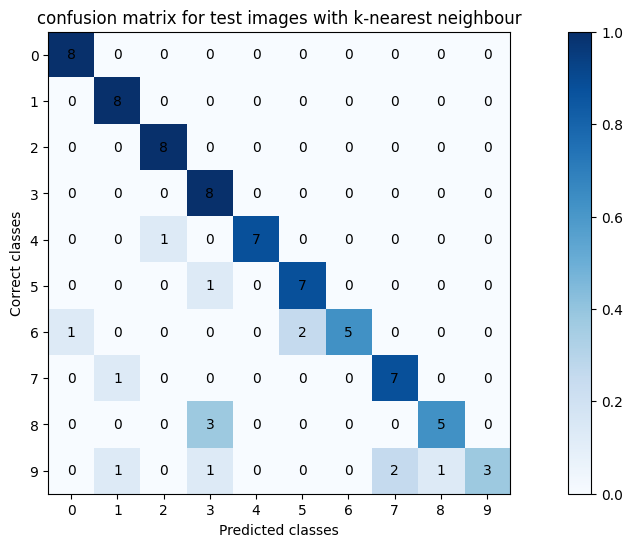

In [13]:
# Fill in the confusion matrix to match the classification result of the three test images
#-------- Your code here --------
confusion_matrix1 = [[8,0,0,0,0,0,0,0,0,0],
                     [0,8,0,0,0,0,0,0,0,0],
                     [0,0,8,0,0,0,0,0,0,0],
                     [0,0,0,8,0,0,0,0,0,0],
                     [0,0,1,0,7,0,0,0,0,0],
                     [0,0,0,1,0,7,0,0,0,0],
                     [1,0,0,0,0,2,5,0,0,0],
                     [0,1,0,0,0,0,0,7,0,0],
                     [0,0,0,3,0,0,0,0,5,0],
                     [0,1,0,1,0,0,0,2,1,3]]
#-----------------------------------

print_confusion_matrix(np.array(confusion_matrix1), 'confusion matrix for test images with k-nearest neighbour')

# Task 2. The effect of balanced and unbalanced teaching data on classifier performance

The second task compares the difference in performance between classifiers taught with balanced and unbalanced data. Many real-life data are unbalanced, with few samples of the phenomenon of interest compared to other categories of data. If the data imbalance is ignored when teaching and testing the classifier, it can have a negative impact on the classifier’s performance and form a false picture of its performance.

Satellite images such as Figure 3 from the sea surface, converted to numerical features, are used as data to detect oil spills. The decoupling of satellite imagery features has been accomplished using digital image processing techniques. The modified 49 features describe e.g. the location of the center of the potential oil spill area in the image, the shape of the area, the area, the intensity, and the roughness of the edge.

A total of 937 samples are included in the data, of which 896 belong to category -1 (no oil leakage) and 41 to category 1 (oil leakage). Divide the data by a ratio of 80:20 into teaching data and test data. The imbalance between teaching data and test data is illustrated by bar graphs. Random forest, logistic regression, and the k-closest neighbor classifier are used as classifiers to solve the problem, the values of the hyperparameters of which are already known in advance and do not need to be validated separately.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='https://github.com/simulate111/Johdatus-teko-lyyn-Introduction-to-Artificial-Intelligence/blob/main/imgs/oil_spill.jpg?raw=1' width='550' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Figure 3. Satellite image of sea level to identify oil spills.</span>
</div>
<br>

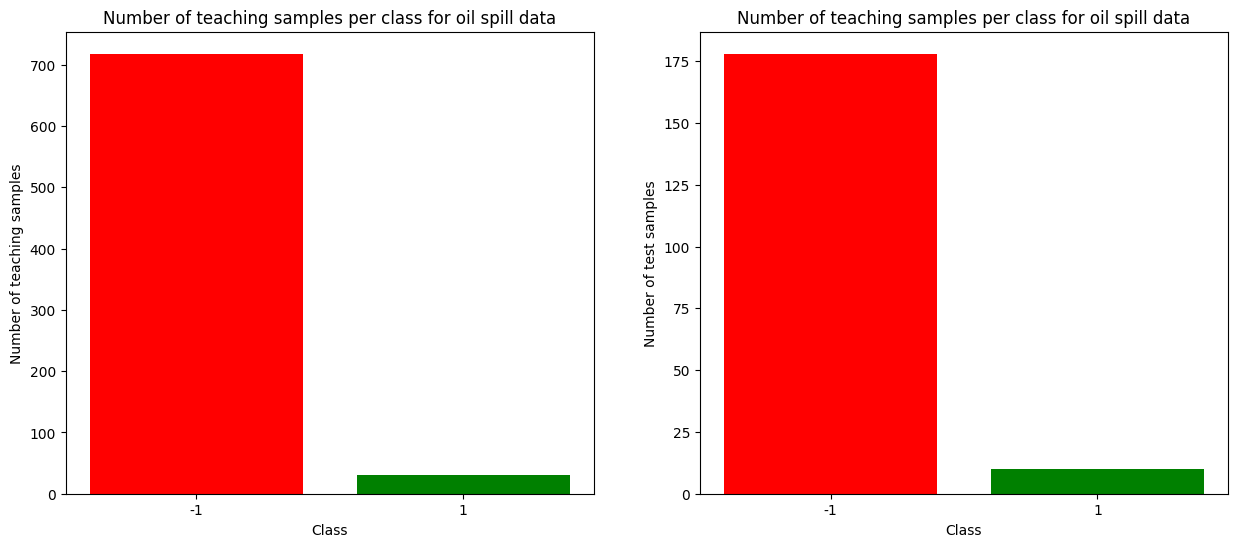

Teaching data class -1 has 718 samples and in class 1 there is 31 samples
Test data class -1 has 178 samples and in class 1 there is 10 samples


In [14]:
# Loading oil leak data. The variable data2 contains 49 features and the variable classes2 class information
data2, classes2 = datasets.fetch_openml('oil_spill', return_X_y=True)
classes2 = np.asarray(classes2, 'int')

# The features are divided into teaching data and test data
data2_teaching, data2_test, classes2_teaching, classes2_test = train_test_split(data2, classes2, test_size=(1/5), random_state=0)

# Illustrate the imbalance of teaching data with a bar chart
plt.subplot(121)
categories_teaching, quantities_teaching = np.unique(classes2_teaching.astype('U'), return_counts=True)
plt.bar(categories_teaching, quantities_teaching, color=['red','green'])
plt.xlabel('Class')
plt.ylabel('Number of teaching samples')
plt.title('Number of teaching samples per class for oil spill data')

# Illustrate the imbalance of test data with a bar chart
plt.subplot(122)
categories_test, quantities_test = np.unique(classes2_test.astype('U'), return_counts=True)
plt.bar(categories_test, quantities_test, color=['red','green'])
plt.xlabel('Class')
plt.ylabel('Number of test samples')
plt.title('Number of teaching samples per class for oil spill data')
plt.show()

# Print the numbers of samples of teaching data and test data per category
print('Teaching data class {} has {} samples and in class {} there is {} samples'.format(categories_teaching[0], quantities_teaching[0], categories_teaching[1], quantities_teaching[1]))
print('Test data class {} has {} samples and in class {} there is {} samples'.format(categories_test[0], quantities_test[0], categories_test[1], quantities_test[1]))

When the data is strongly unbalanced, the classification accuracy does not give a true picture of the classifier’s performance. Often, classifiers learn to identify majority-class samples well, but identification of minority-class samples of interest is poor. For example, if the classifier identified all samples of the oil leakage classification problem test data as class -1, a classification accuracy of 94.7% would be achieved, even though no classification has actually occurred. This phenomenon is called the classification accuracy paradox. For this reason, instead of classification accuracy, measures such as sensitivity/recall/true positive rate and positive predictive value/accuracy are used for unbalanced data to assess how well the classifier actually performs the classification.

Evaluate the performance of taught classifiers from the confusion matrices of test data for a binary two-class classification problem. We compare performance measures of classification accuracy, sensitivity, positive predictive value, and F1 score, which are calculated by the following equations.

<br><br>
\begin{equation}
\text{classification accuracy} = \frac{TP+TN}{P+N} = \frac{TP+TN}{TP+FN+TN+FP}
\end{equation}

<br><br>
\begin{equation}
\text{recall} = \frac{TP}{P} = \frac{TP}{TP+FN}
\end{equation}

<br><br>
\begin{equation}
\text{precision} = \frac{TP}{TP+FP}
\end{equation}

<br><br>
\begin{equation}
\text{F1 score} = \frac{2 \cdot \text{recall} \cdot \text{precision}}{\text{recall}+\text{precision}}
\end{equation}
<br><br>

The F1 value is the harmonic mean of the sensitivity and the positive predictive value. Implement the performance dimensions of the equations.

After completing the measurements, check again with the oil spill-taught random forest that you get the correct values using sckit-learn library functions [metrics.accuracy_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), [metrics.recall_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html), [metrics.precision_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) and [metrics.f1_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

In [15]:
def calculate_classification_accuracy(confusion_matrix):
    """
    This function calculates classification accuracy from a 2x2 confusion matrix.
    """
    TN, FP, FN, TP = confusion_matrix.ravel()
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Function returns accuracy
    return accuracy

def calculate_recall(confusion_matrix):
    """
    This function calculates recall from a 2x2 confusion matrix.
    """
    TN, FP, FN, TP = confusion_matrix.ravel()
    # Calculate recall
    recall = TP / (TP + FN)
    # Function returns recall
    return recall

def calculate_precision(confusion_matrix):
    """
    This function calculates precision from a 2x2 confusion matrix.
    """
    TN, FP, FN, TP = confusion_matrix.ravel()
    # Calculate precision
    precision = TP / (TP + FP)
    # Function returns precision
    return precision

def calculate_f1_score(recall, precision):
    """
    This function calculates F1 score from recall and precision.
    """
    # Calculate F1 score
    if recall + precision == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
    # Function returns F1-score
    return f1_score

# Teach random forest and place predicted values of test data into confusion matrix
classifier2_random_forest = RandomForestClassifier(n_estimators=100, random_state=0).fit(data2_teaching, classes2_teaching)
confusion_matrix2_random_forest = confusion_matrix(classes2_test,classifier2_random_forest.predict(data2_test))

print('Classification accuracy for random forest with ready-made function in scikit-learn library: {}'.format(accuracy_score(classes2_test, classifier2_random_forest.predict(data2_test))))
print('Recall for random forest with ready-made function in scikit-learn library: {}'.format(recall_score(classes2_test, classifier2_random_forest.predict(data2_test))))
print('Precision for random forest with ready-made function in scikit-learn library: {}'.format(precision_score(classes2_test, classifier2_random_forest.predict(data2_test))))
print('F1 score for random forest with ready-made function in scikit-learn library: {}'.format(f1_score(classes2_test, classifier2_random_forest.predict(data2_test))))

print('\nClassification accuracy for random forest with function made by you: {}'.format(calculate_classification_accuracy(confusion_matrix2_random_forest)))
print('Recall for random forest with function made by you: {}'.format(calculate_recall(confusion_matrix2_random_forest)))
print('Precision for random forest with function made by you: {}'.format(calculate_precision(confusion_matrix2_random_forest)))
print('F1 score for random forest with function made by you:: {}'.format(calculate_f1_score(calculate_recall(confusion_matrix2_random_forest), calculate_precision(confusion_matrix2_random_forest))))

Classification accuracy for random forest with ready-made function in scikit-learn library: 0.9680851063829787
Recall for random forest with ready-made function in scikit-learn library: 0.5
Precision for random forest with ready-made function in scikit-learn library: 0.8333333333333334
F1 score for random forest with ready-made function in scikit-learn library: 0.625

Classification accuracy for random forest with function made by you: 0.9680851063829787
Recall for random forest with function made by you: 0.5
Precision for random forest with function made by you: 0.8333333333333334
F1 score for random forest with function made by you:: 0.625


In addition, logistic regression and the k-nearest neighbor classifier are taught with teaching samples of unbalanced oil spill data. Plot ROC curves for all three classifiers on the graph and calculate the corresponding ROC AUC values.

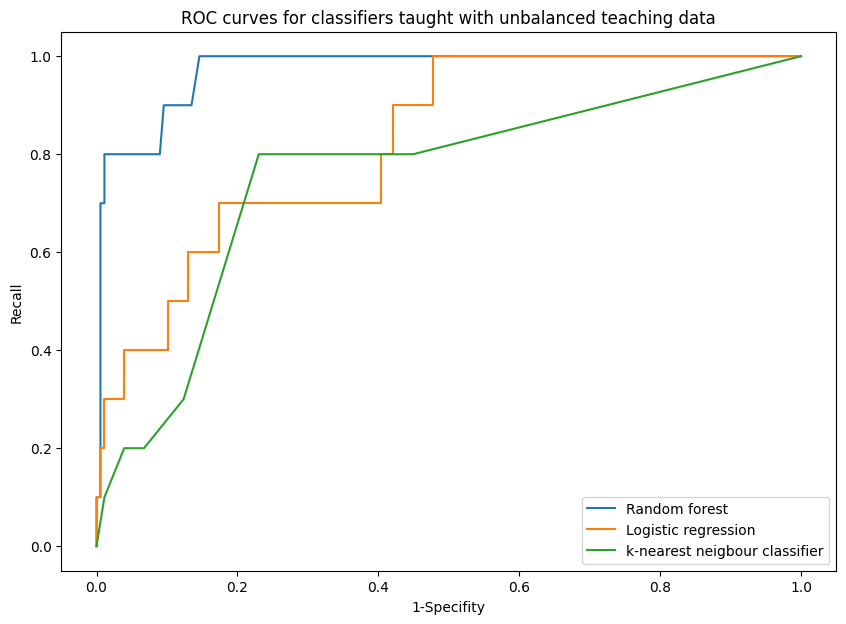

Random forest ROC AUC value: 0.972
Logistic regression ROC AUC value: 0.824
k-nearest neigbour  ROC AUC value: 0.754


In [16]:
# Teaching logistic regression and k-nearest neighbor classifier with oil spill data teaching samples
classifier2_logistic_regression = LogisticRegression(C=50, solver='liblinear', random_state=0).fit(data2_teaching, classes2_teaching)
classifier2_knn = KNeighborsClassifier(n_neighbors=35).fit(data2_teaching, classes2_teaching)

# Calculate the posterior probabilities of the test data
posterior_probablity_random_forest = classifier2_random_forest.predict_proba(data2_test)[:, 1]
posterior_probablity_logistic_regression = classifier2_logistic_regression.predict_proba(data2_test)[:, 1]
posterior_probablity_knn = classifier2_knn.predict_proba(data2_test)[:, 1]

# Calculate ROC-curves
fpr_random_forest, tpr_random_forest, _ = roc_curve(classes2_test, posterior_probablity_random_forest)
fpr_logistic_regression, tpr_logistic_regression, _ = roc_curve(classes2_test, posterior_probablity_logistic_regression)
fpr_knn, tpr_knn, _ = roc_curve(classes2_test, posterior_probablity_knn)

# Draw the ROC curves of all three classifiers on the graph
plt.figure(figsize=(10,7))
plt.plot(fpr_random_forest, tpr_random_forest, label='Random forest')
plt.plot(fpr_logistic_regression, tpr_logistic_regression, label='Logistic regression')
plt.plot(fpr_knn, tpr_knn, label='k-nearest neigbour classifier')
plt.xlabel('1-Specifity')
plt.ylabel('Recall')
plt.title('ROC curves for classifiers taught with unbalanced teaching data')
plt.legend()
plt.show()

# Print ROC AUC values corresponding the ROC curves
print('Random forest ROC AUC value: {}'.format(round(roc_auc_score(classes2_test, posterior_probablity_random_forest),3)))
print('Logistic regression ROC AUC value: {}'.format(round(roc_auc_score(classes2_test, posterior_probablity_logistic_regression),3)))
print('k-nearest neigbour  ROC AUC value: {}'.format(round(roc_auc_score(classes2_test, posterior_probablity_knn),3)))

Plot a precision - recall curves for the classifiers and calculate the corresponding PR AUC values.

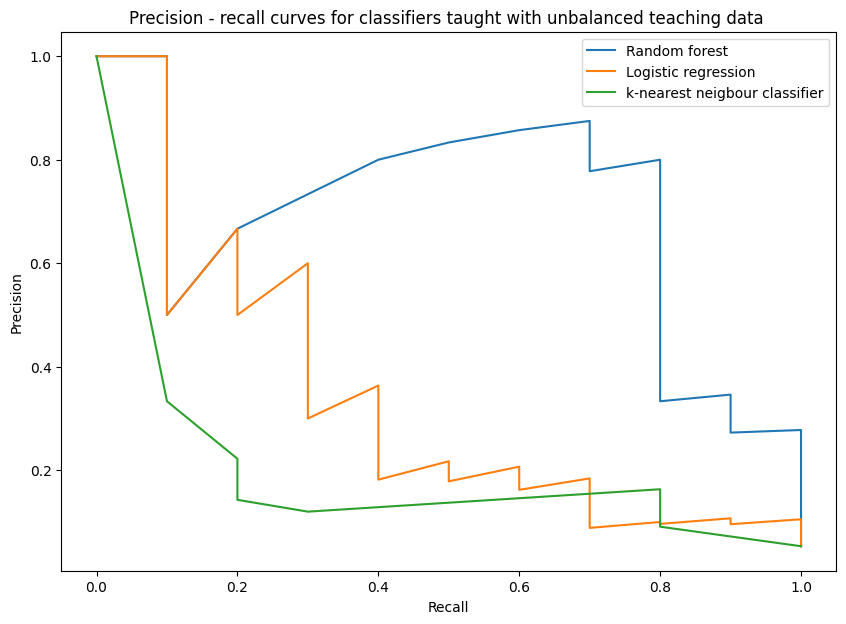

Random forest PR AUC value: 0.698
Logistic regression PR AUC value: 0.333
k-nearest neigbour classifier PR AUC value: 0.193


In [17]:
# Calculate PR curves
precision_values_random_forest, recalls_random_forest, _ = precision_recall_curve(classes2_test, posterior_probablity_random_forest)
precision_values_logistic_regression, recalls_logistic_regression, _ = precision_recall_curve(classes2_test, posterior_probablity_logistic_regression)
precision_values_knn, recalls_knn, _ = precision_recall_curve(classes2_test, posterior_probablity_knn)

# Draw the PR curves of all three classifiers on the graph
plt.figure(figsize=(10,7))
plt.plot(recalls_random_forest, precision_values_random_forest, label='Random forest')
plt.plot(recalls_logistic_regression, precision_values_logistic_regression, label='Logistic regression')
plt.plot(recalls_knn, precision_values_knn, label='k-nearest neigbour classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - recall curves for classifiers taught with unbalanced teaching data ')
plt.legend()
plt.show()

# Print PR AUC values corresponding to PR curves
print('Random forest PR AUC value: {}'.format(round(auc(recalls_random_forest, precision_values_random_forest),3)))
print('Logistic regression PR AUC value: {}'.format(round(auc(recalls_logistic_regression, precision_values_logistic_regression),3)))
print('k-nearest neigbour classifier PR AUC value: {}'.format(round(auc(recalls_knn, precision_values_knn),3)))

Finally, all measurement values describing the performance of the classifiers are calculated and presented in a table.

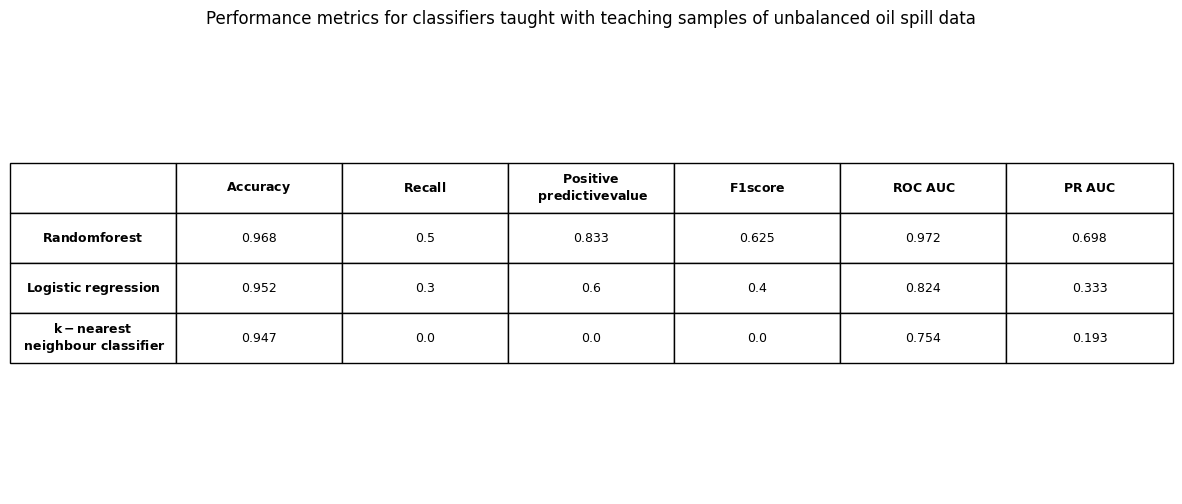

In [18]:
def calculate_measurement_values(data_test, classes_test, classifier, classifier_name):
    """
    This function calculates measurement values of classifier and saves them to list
    """
    # Calculate accuracy, recall, precision, F1 score, ROC AUC value ja PR AUC value
    accuracy = round(accuracy_score(classes_test, classifier.predict(data_test)),3)
    recall = round(recall_score(classes_test, classifier.predict(data_test)),3)
    precision = round(precision_score(classes_test, classifier.predict(data_test)),3)
    f1_arvo = round(f1_score(classes_test, classifier.predict(data_test)),3)
    roc_auc = round(roc_auc_score(classes_test, classifier.predict_proba(data_test)[:, 1]),3)
    precision_values, recalls, _ = precision_recall_curve(classes_test, classifier.predict_proba(data_test)[:, 1])
    pr_auc = round(auc(recalls, precision_values),3)
    return [classifier_name, accuracy, recall, precision, f1_arvo, roc_auc, pr_auc]

# A table is made to show the performance measurements
measurement_values = []
measurement_values.append(['','$\\bf{Accuracy}$','$\\bf{Recall}$','$\\bf{Positive}$\n $\\bf{predictive value}$','$\\bf{F1 score}$','$\\bf{ROC\\ AUC}$','$\\bf{PR\\ AUC}$'])
measurement_values.append(calculate_measurement_values(data2_test, classes2_test, classifier2_random_forest, '$\\bf{Random forest}$'))
measurement_values.append(calculate_measurement_values(data2_test, classes2_test, classifier2_logistic_regression, '$\\bf{Logistic\\ regression}$'))
measurement_values.append(calculate_measurement_values(data2_test, classes2_test, classifier2_knn, '$\\bf{k-nearest}$\n $\\bf{neighbour\\ classifier}$'))

# print table
table = plt.gca().table(cellText=measurement_values, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1,3)
plt.gca().axis('off')
plt.title('Performance metrics for classifiers taught with teaching samples of unbalanced oil spill data')
plt.show()

**List the classifiers in order of priority based on performance measures, ROC curves, and precision - recall curves.**

`Random forest; Logistic regression; k-nearest neighbour classifier.`

## Oversampling of teaching data

Oversampling the training data with the SVMSMOTE algorithm to improve the performance of the classifiers. Illustrate the imbalance of oversampled teaching data with a bar graph. The bar chart shows that the number of samples of the minority class of interest has increased, but the number of samples of the majority class has remained the same. The amount of imbalances has decreased significantly.

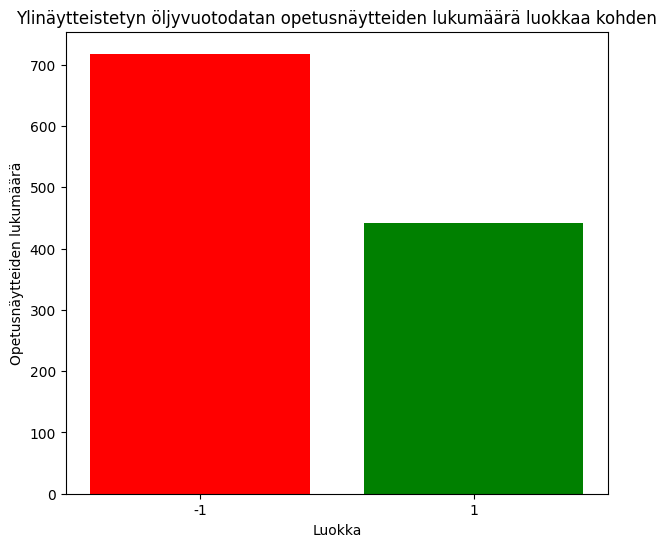

Opetusdatan luokassa -1 on 718 näytettä ja luokassa 1 on 441 näytettä


In [19]:
# Oversampling with the SVMSMOTE algorithm
data2_teaching_oversampled, classes2_teaching_oversampled = SVMSMOTE(random_state=0).fit_resample(data2_teaching, classes2_teaching)

# Havainnollistetaan opetusdatan epäbalanssia pylväsdiagrammilla
plt.figure(figsize=(7,6))
categories_teaching_oversampled, quantities_teaching_oversampled = np.unique(classes2_teaching_oversampled.astype('U'), return_counts=True)
plt.bar(categories_teaching_oversampled, quantities_teaching_oversampled, color=['red','green'])
plt.xlabel('Luokka')
plt.ylabel('Opetusnäytteiden lukumäärä')
plt.title('Ylinäytteistetyn öljyvuotodatan opetusnäytteiden lukumäärä luokkaa kohden')
plt.show()

# Print the number of samples of teaching data per class
print('Opetusdatan luokassa {} on {} näytettä ja luokassa {} on {} näytettä'.format(categories_teaching_oversampled[0], quantities_teaching_oversampled[0], categories_teaching_oversampled[1], quantities_teaching_oversampled[1]))

Taught with oversampled oil spill data's teaching samples using random forest, logistic regression, and k-nearest neighbor classifiers. Plot ROC curves for all three classifiers on the graph and calculate the corresponding ROC AUC values.

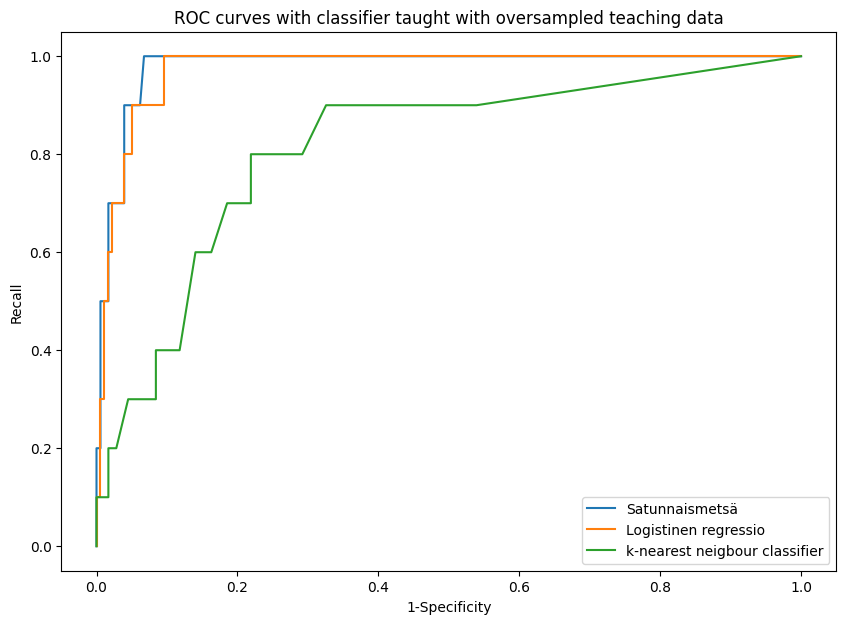

Random forest ROC AUC value: 0.981
Logistic regression ROC AUC value: 0.974
k-nearest neigbour classifier ROC AUC value: 0.813


In [20]:
# Teach random forest, logistic regression and k-nearest neighbour classifiers with oversampled oil spillage data
classifier2_random_forest_oversampled = RandomForestClassifier(n_estimators=100, random_state=0).fit(data2_teaching_oversampled, classes2_teaching_oversampled)
classifier2_logistic_regression_oversampled = LogisticRegression(C=50, solver='liblinear', random_state=0).fit(data2_teaching_oversampled, classes2_teaching_oversampled)
classifier2_knn_oversampled = KNeighborsClassifier(n_neighbors=35).fit(data2_teaching_oversampled, classes2_teaching_oversampled)

# Calculate posterior probabilities for test data
posterior_probablity_random_forest_oversampled = classifier2_random_forest_oversampled.predict_proba(data2_test)[:, 1]
posterior_probablity_logistic_regression_oversampled = classifier2_logistic_regression_oversampled.predict_proba(data2_test)[:, 1]
posterior_probablity_knn_oversampled = classifier2_knn_oversampled.predict_proba(data2_test)[:, 1]

# Calculate Roc-curves
fpr_random_forest_oversampled, tpr_random_forest_oversampled, _ = roc_curve(classes2_test, posterior_probablity_random_forest_oversampled)
fpr_logistic_regression_oversampled, tpr_logistic_regression_oversampled, _ = roc_curve(classes2_test, posterior_probablity_logistic_regression_oversampled)
fpr_knn_oversampled, tpr_knn_oversampled, _ = roc_curve(classes2_test, posterior_probablity_knn_oversampled)

# Draw the ROC curves of all three classifiers on the graph
plt.figure(figsize=(10,7))
plt.plot(fpr_random_forest_oversampled, tpr_random_forest_oversampled, label='Satunnaismetsä')
plt.plot(fpr_logistic_regression_oversampled, tpr_logistic_regression_oversampled, label='Logistinen regressio')
plt.plot(fpr_knn_oversampled, tpr_knn_oversampled, label='k-nearest neigbour classifier')
plt.xlabel('1-Specificity')
plt.ylabel('Recall')
plt.title('ROC curves with classifier taught with oversampled teaching data')
plt.legend()
plt.show()

# Print ROC AUC values corresponding to ROC-curves
print('Random forest ROC AUC value: {}'.format(round(roc_auc_score(classes2_test, posterior_probablity_random_forest_oversampled),3)))
print('Logistic regression ROC AUC value: {}'.format(round(roc_auc_score(classes2_test, posterior_probablity_logistic_regression_oversampled),3)))
print('k-nearest neigbour classifier ROC AUC value: {}'.format(round(roc_auc_score(classes2_test, posterior_probablity_knn_oversampled),3)))

Plot a positive predictive value for the classifiers - recall the curves and calculate the corresponding PR AUC values.

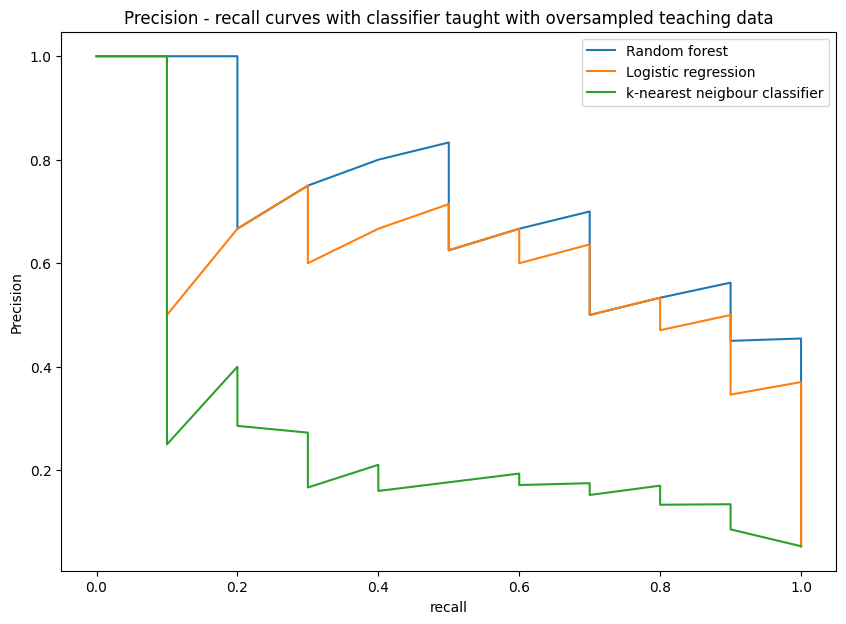

Random forest PR AUC value: 0.715
Logistic regression PR AUC value: 0.624
k-nearest neigbour classifiern PR AUC value: 0.268


In [21]:
# Calculate PR curves
precision_values_random_forest_oversampled, recalls_random_forest_oversampled, _ = precision_recall_curve(classes2_test, posterior_probablity_random_forest_oversampled)
precision_values_logistic_regression_oversampled, recalls_logistic_regression_oversampled, _ = precision_recall_curve(classes2_test, posterior_probablity_logistic_regression_oversampled)
precision_values_knn_oversampled, recalls_knn_oversampled, _ = precision_recall_curve(classes2_test, posterior_probablity_knn_oversampled)

# Draw the PR curves of all three classifiers on the graph
plt.figure(figsize=(10,7))
plt.plot(recalls_random_forest_oversampled, precision_values_random_forest_oversampled, label='Random forest')
plt.plot(recalls_logistic_regression_oversampled, precision_values_logistic_regression_oversampled, label='Logistic regression')
plt.plot(recalls_knn_oversampled, precision_values_knn_oversampled, label='k-nearest neigbour classifier')
plt.xlabel('recall')
plt.ylabel('Precision')
plt.title('Precision - recall curves with classifier taught with oversampled teaching data')
plt.legend()
plt.show()

# Print ROC AUC values corresponding to ROC-curves
print('Random forest PR AUC value: {}'.format(round(auc(recalls_random_forest_oversampled, precision_values_random_forest_oversampled),3)))
print('Logistic regression PR AUC value: {}'.format(round(auc(recalls_logistic_regression_oversampled, precision_values_logistic_regression_oversampled),3)))
print('k-nearest neigbour classifiern PR AUC value: {}'.format(round(auc(recalls_knn_oversampled, precision_values_knn_oversampled),3)))

Lasketaan lopuksi kaikki luokittelijoiden suorituskykyä kuvaavat mitta-values ja esitetään ne taulukossa.

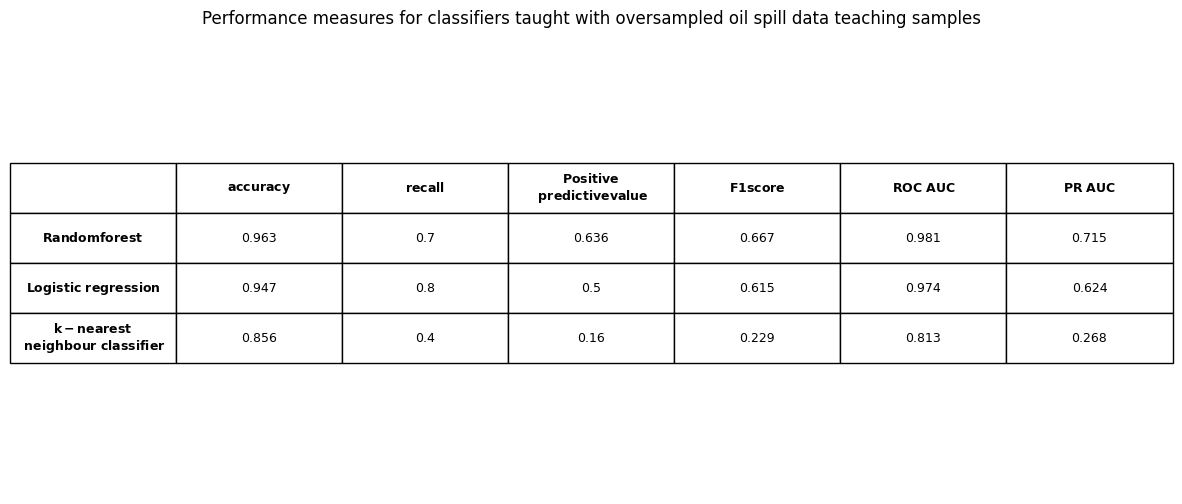

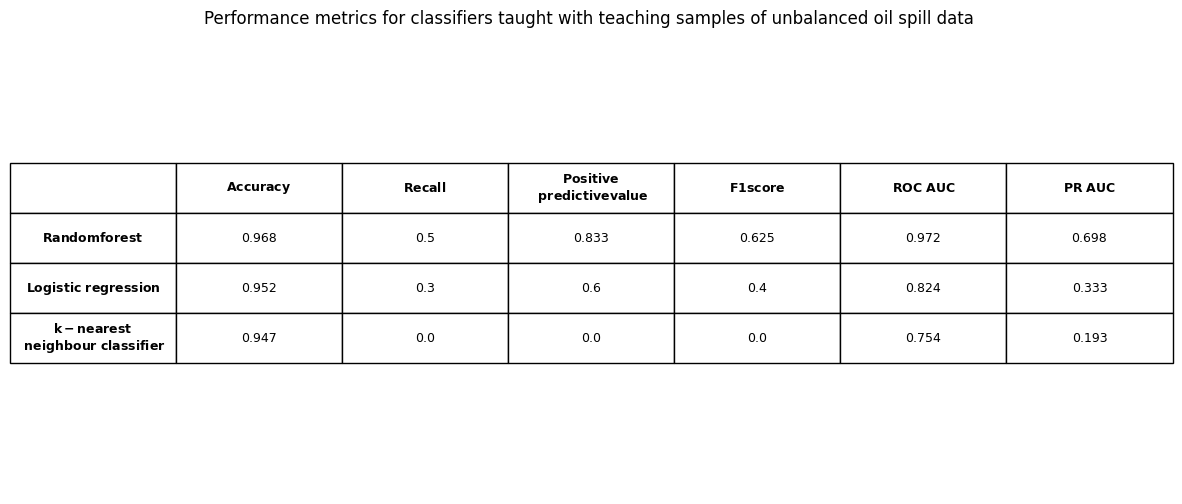

In [22]:
# Make table for presenting performance measurement values
measurement_values_oversampled = []
measurement_values_oversampled.append(['','$\\bf{accuracy}$','$\\bf{recall}$','$\\bf{Positive}$\n $\\bf{predictive value}$','$\\bf{F1 score}$','$\\bf{ROC\\ AUC}$','$\\bf{PR\\ AUC}$'])
measurement_values_oversampled.append(calculate_measurement_values(data2_test, classes2_test, classifier2_random_forest_oversampled, '$\\bf{Random forest}$'))
measurement_values_oversampled.append(calculate_measurement_values(data2_test, classes2_test, classifier2_logistic_regression_oversampled, '$\\bf{Logistic\\ regression}$'))
measurement_values_oversampled.append(calculate_measurement_values(data2_test, classes2_test, classifier2_knn_oversampled, '$\\bf{k-nearest}$\n $\\bf{neighbour\\ classifier}$'))

# For comparison, both tables are printed one below the other
table_oversampled = plt.gca().table(cellText=measurement_values_oversampled, loc='center', cellLoc='center')
table_oversampled.auto_set_font_size(False)
table_oversampled.set_fontsize(9)
table_oversampled.scale(1,3)
plt.gca().axis('off')
plt.title('Performance measures for classifiers taught with oversampled oil spill data teaching samples')

plt.figure()
table = plt.gca().table(cellText=measurement_values, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1,3)
plt.gca().axis('off')
plt.title('Performance metrics for classifiers taught with teaching samples of unbalanced oil spill data ')
plt.show()

**Compare the measured values, ROC curves, and precision-recall curves of the k-closest neighbor classifier taught with the original teaching data and the k-nearest neighbor taught with the oversampled teaching data. Did the classifier's performance improve when samples from a particular minority class were to be correctly identified?**

`Using oversampled lead to higher performance in k-nearest neighbor classifier compared to unbalanced data split.`

# Feedback

Finaly answer following questions

**How much time did you spend doing this exercise?**

`Your answer here`

**Did you encounter any problems or challenges while doing the exercise? Were the notebook sufficiently comprehensive instructions for doing the exercise?**

`Your answer here`

**Other feedback related to to this exercise**

`Your answer here`

# Returning the exercise

1. Before you return this notebook **make sure that code in notebook works properly** and returns all necessary values by choosing from menu `Kernel -> Restart & Run All`! also make sure you have answer all questions on **bold**
2. **Contrary to previous exercises** do not clear the printouts and variables, but press the save button after completing Step 1!
3. Rename this notebook in following format **`JT_H3_[student_number(s)].ipynb`** (e.g `JT_H3_1234567.ipynb` or if you have group `JT_H3_1234567_2345678_3456789.ipynb`)
4. Return **only** solved notebook(`file ending with .ipynb`) to moodle programming exercise 3. Everyone must return file to moodle even if you work in a group. **Don't include working directory or other files** when you return the exercise.
5. Finally go answer questions in moodle related to programming exercise 3. Everyone in your group must answer to questions.